In [1]:
import numpy as np
from scipy import optimize as op
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from fp_plotting_funcs import *
from statistics import median

/Users/pnr5sh/miniconda3/envs/astro/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Uncleaned Lightcurves - 20ano')

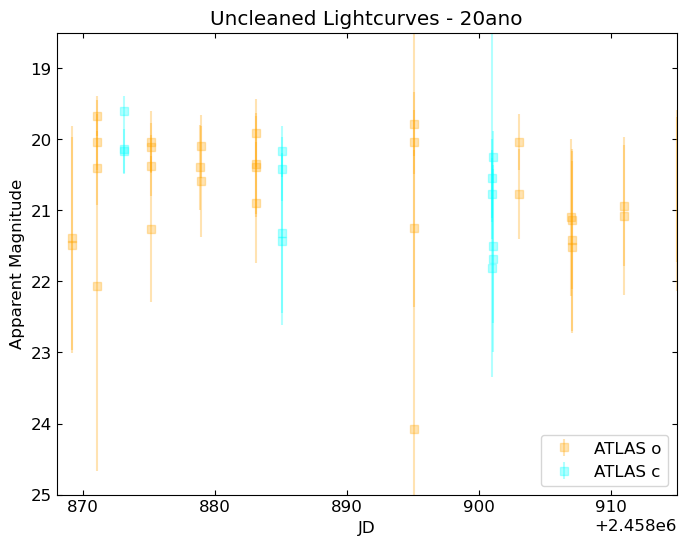

In [2]:
sn20ano_ztf = read_in_data('../../data/forced_phot_data/20ano_fp_lc.txt', data_source='ztf_fp')

sn20ano_at = read_in_data('../../data/forced_phot_data/sn20ano_atlas.txt', data_source='atlas')

multi_band_plot(sn20ano_ztf, _, sn20ano_at, ID='20ano', xlims=[868+2.458e6, 915+2.458e6], ylims=[25,18.5],save=False, ztf=False, atlas=True, asassn=False)
plt.title('Uncleaned Lightcurves - 20ano')

In [3]:
# testing to see if i can make similar atlas averaged light curve - IN FLUX
tstart = 868+2.458e6
tend = 915+2.458e6
sn20ano_at_cut = sn20ano_at[(tstart<sn20ano_at['JD'])&(sn20ano_at['JD']<tend)]
print(sn20ano_at_cut.columns)
o = np.where(sn20ano_at_cut['F']=='o')
c = np.where(sn20ano_at_cut['F']=='c')

jd_o_avgs, flux_o_avgs, flux_o_errs = [],[],[]
for i in range(len(sn20ano_at_cut.JD.values[o])):
    t_i = np.array(sn20ano_at_cut.JD.values[o])[i]
    t_around = np.where((t_i-0.5<=sn20ano_at_cut.JD.values[o])&(sn20ano_at_cut.JD.values[o]<=t_i+0.5))

    jd_avg = sn20ano_at_cut.JD.values[o][t_around].mean()
    flux_o_avg = sn20ano_at_cut.uJy.values[o][t_around].mean()
    flux_o_err = np.sqrt(sum([val**2 for val in sn20ano_at_cut.duJy.values[o][t_around]]))

    # flux_o_avg = (sn20ano_at_cut.uJy.values[o][t_around]*sn20ano_at_cut.duJy.values[o][t_around]).sum() / sn20ano_at_cut.duJy.values[o][t_around].sum()
    # flux_o_err = np.sqrt(sum([val**2 for val in (sn20ano_at_cut.duJy.values[o][t_around]/sn20ano_at_cut.uJy.values[o][t_around])]))

    jd_o_avgs.append(jd_avg)
    flux_o_avgs.append(flux_o_avg)
    flux_o_errs.append(flux_o_err)
jd_o_avgs = pd.Series(jd_o_avgs).unique()
flux_o_avgs = pd.Series(flux_o_avgs).unique()
flux_o_errs = pd.Series(flux_o_errs).unique()

Index(['JD', 'MJD', 'm', 'dm', 'uJy', 'duJy', 'F', 'err', 'chi/N', 'RA', 'Dec',
       'x', 'y', 'maj', 'min', 'phi', 'apfit', 'mag5sig', 'Sky', 'Obs'],
      dtype='object')


In [4]:
#cleaning data

In [5]:
def get_mag_from_atlas_fp(filename):
    """
    Processes the results of an ATLAS FP request into final magnitudes.
    Takes as input the name of a file containing raw ATLAS FP data
    and returns a dictionary of cleaned, final magnitudes
    """

    cols_atlas = ['MJD', 'm', 'dm', 'uJy', 'duJy', 'F', 'err', 'chi/N', 'RA', 'Dec', 'x', 'y', 'maj', 'min', 'phi', 'apfit', 'mag5sig', 'Sky', 'Obs']
    full_df = pd.read_csv(filename, skiprows=1, names=cols_atlas, delim_whitespace=True)
    
    colors = {'c': 'cyan', 'o': 'orange'}
    atlas_data = {}
    for filt in ['c', 'o']:

        df = full_df[(full_df['F'] == filt) & (full_df['chi/N'] < 2.0)]
        df = df.reset_index(drop=True)

        if len(df) == 0:
            continue

        mjdmin = int(df['MJD'].iloc[0]) - 1
        mjdmax = int(df['MJD'].iloc[-1]) - 1
        mjds = np.linspace(mjdmin, mjdmax, int(mjdmax-mjdmin)+1)

        ### Bin dataframe by mjds
        df['bin'] = pd.cut(df['MJD'], mjds, labels=mjds[:-1])
        
        for mjd in mjds:
            # Get rows that fell into this bin

            good = np.where((df['bin'] == mjd))[0]
            if len(good) == 0:
                continue

            avg_mjd = np.average(df['MJD'][good])
            avg_fluxes = np.average(df['uJy'][good], weights=1/df['duJy'][good].values**2)
            avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df['duJy'][good].values]))

            if avg_fluxes / avg_flux_errs > 3:
                avg_mag = -2.5*np.log10(avg_fluxes) + 23.9
                avg_mag_err = 1.0857 * avg_flux_errs / avg_fluxes

                plt.errorbar(avg_mjd, avg_mag, yerr=avg_mag_err, fmt='o', color=colors[filt], mec='black')

            else:
                avg_mag = -2.5*np.log10(5 * avg_flux_errs) + 23.9
                avg_mag_err = 9999

                plt.scatter(avg_mjd, avg_mag, marker='v', color=colors[filt], edgecolor='black', alpha=0.5)

            atlas_data.setdefault(filt, []).append({'mag': avg_mag, 'err': avg_mag_err, 'mjd': avg_mjd})

    plt.gca().invert_yaxis()
    plt.show()

    return atlas_data   

In [22]:
def process_ztf_fp(filename, jdstart, jdend):

    """
    Processes the raw ZTF forced photometry from saved file
    and returns a Pandas dataframe of the cleaned data
    """

    full_df = pd.read_csv(filename, delim_whitespace=True, comment='#', header=0, names=['sindex', 'field', 'ccdid', 'qid', 'filter',
                            'pid', 'infobitssci', 'sciinpseeing',
                            'scibckgnd', 'scisigpix', 'zpmaginpsci',
                            'zpmaginpsciunc', 'zpmaginpscirms',
                            'clrcoeff', 'clrcoeffunc', 'ncalmatches',
                            'exptime', 'adpctdif1', 'adpctdif2',
                            'diffmaglim', 'zpdiff', 'programid', 'jd',
                            'rfid', 'forcediffimflux',
                            'forcediffimfluxunc', 'forcediffimsnr',
                            'forcediffimchisq', 'forcediffimfluxap',
                            'forcediffimfluxuncap', 'forcediffimsnrap',
                            'aperturecorr', 'dnearestrefsrc',
                            'nearestrefmag', 'nearestrefmagunc',
                            'nearestrefchi', 'nearestrefsharp',
                            'refjdstart', 'refjdend', 'procstatus'])

    # Get rid of bad data
    df = full_df[(full_df['infobitssci'] < 33554432) & (full_df['scisigpix'] <= 25) & (full_df['sciinpseeing'] <= 4)]
    df = full_df.reset_index(drop=True)

    # Make baseline correction
    colors = {'ZTF_g': 'green', 'ZTF_r': 'red', 'ZTF_i': 'brown'}
    plt.figure()

    for filt in ['ZTF_g', 'ZTF_r', 'ZTF_i']:
        ### Get unique values of field, ccdid, qid
        fields = set(df[df['filter'] == filt]['field'].values)
        ccdids = set(df[df['filter'] == filt]['ccdid'].values)
        qids = set(df[df['filter'] == filt]['qid'].values)        
       
        for field in fields:
            for ccdid in ccdids:
                for qid in qids:
                    current_df = df[(df['filter'] == filt) & (df['field'] == field) & (df['ccdid'] == ccdid) & 
                                    (df['qid'] == qid) & ((df['jd'] < jdstart - 20) | (df['jd'] > jdend + 20))]
                    if len(current_df.index) < 30:
                        print('Not enough epochs to estimate baseline for ', filt)
                        continue

                    plt.errorbar(current_df['jd'], current_df['forcediffimflux'], yerr=abs(current_df['forcediffimfluxunc']),
                                 fmt='o', color=colors[filt], mec='k', label=filt)
                    median_flux = median(current_df['forcediffimflux'])
                    print(filt, median_flux)
                    df.loc[(df['filter'] == filt) & (df['field'] == field) & (df['ccdid'] == ccdid) & (df['qid'] == qid), 'forcediffimflux'] -= median_flux        
    plt.legend()
    plt.xlim(jdstart-100, jdend+100)
    plt.title('corrected/cleaned flux')
    plt.show()

    return df


def get_mag_from_ztf_fp(full_df):

    """
    Takes as input a dataframe of cleaned ZTF forced photometry
    and returns a dictionary fo the stacked, magnitude-calibrated
    final photometry
    """
    
    colors = {'ZTF_g': 'green', 'ZTF_r': 'red', 'ZTF_i': 'brown'}
    ztf_data = {}

    ### Bin dataframe by jd
    jdmin = int(full_df['jd'].iloc[0]) - 1
    jdmax = int(full_df['jd'].iloc[-1]) - 1
    jds = np.linspace(jdmin, jdmax, int(jdmax-jdmin)+1)
    full_df['bin'] = pd.cut(full_df['jd'], jds, labels=jds[:-1])

    plt.figure() 
    
    for filt in ['ZTF_g', 'ZTF_r', 'ZTF_i']:
        df = full_df[full_df['filter'] == filt]
        mags, mag_errs, uplims = [],[],[]
        
        for d in jds:
            # Get rows that fell into this bin
            inbin = np.where((df['bin'] == d))[0]
            if len(inbin) == 0:
                continue

            avg_jd = np.average(df.jd.values[inbin])
            avg_fluxes = np.average(df.forcediffimflux.values[inbin], weights=1/df.forcediffimfluxunc.values[inbin]**2)
            avg_flux_errs = 1 / np.sqrt(sum([1/err**2 for err in df.forcediffimfluxunc.values[inbin]]))
            avg_zpdiff = np.average(df.zpdiff.values[inbin])

            # if avg_fluxes / avg_flux_errs > 3:
            #     avg_mag = -2.5*np.log10(avg_fluxes) + 23.9
            #     avg_mag_err = 1.0857 * avg_flux_errs / avg_fluxes
            #     # plt.errorbar(avg_mjd, avg_mag, yerr=avg_mag_err, fmt='o', color=colors[filt], mec='black')
            # else:
            #     avg_mag = -2.5*np.log10(5 * avg_flux_errs) + 23.9
            #     avg_mag_err = 9999

            #     # plt.scatter(avg_mjd, avg_mag, marker='v', color=colors[filt], edgecolor='black', alpha=0.5)
            # atlas_data.setdefault(filt, []).append({'mag': avg_mag, 'err': avg_mag_err, 'mjd': avg_mjd})


            # # df['nearestrefflux'] = 10**(0.4 * (df['zpdiff'] - df['nearestrefmag']))
            # # df['nearestreffluxunc'] = df['nearestrefmagunc'] * df['nearestrefflux'] / 1.0857

            snt = 3
            snu = 5

            df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],
                                inplace=True)
            df = df.reset_index(drop=True)
            m, dm, uplim = float(), float(), float()
            if avg_fluxes / avg_flux_errs > snt: # good measurement
                m = avg_zpdiff - 2.5*np.log10(avg_fluxes)
                dm = 1.0857 * avg_flux_errs / avg_fluxes
                mags.append(m)
                mag_errs.append(dm)
                plt.errorbar(avg_jd, m, yerr=dm, fmt='o', color=colors[filt], mec='black', label=filt)
            else:
                uplim = avg_zpdiff - 2.5*np.log10(snu * avg_flux_errs)
                dm = 9999
                uplims.append(uplim)
                mag_errs.append(dm)
                plt.scatter(avg_jd, uplim, marker='v', color=colors[filt], edgecolor='black')
            
            ztf_data.setdefault(filt, []).append({'mag': m, 'err': dm, 'mjd': avg_jd-2400000.5})
        
        # good_jds = df['jd'][good].to_numpy()
        # good_mags = df['mag'][good].to_numpy()
        # good_errs = df['sigma_mag'][good].to_numpy()
        
        # for i in range(len(good_jds)):
        #     ztf_data.setdefault(filt.replace('ZTF_', ''), []).append({'mag': good_mags[i], 'err': good_errs[i], 'mjd': good_jds[i]-2400000.5})
        
        
        # bad_jds = df['jd'][bad].to_numpy()
        # bad_mags = df['mag'][bad].to_numpy()
        
        # for i in range(len(bad_jds)):
        #     ztf_data.setdefault(filt.replace('ZTF_', ''), []).append({'mag': bad_mags[i], 'err': 9999, 'mjd': bad_jds[i]-2400000.5})
        
    plt.gca().invert_yaxis()
    # plt.legend()
    plt.title('cleaned+binned in magnitude')
    plt.show()
    
    return ztf_data

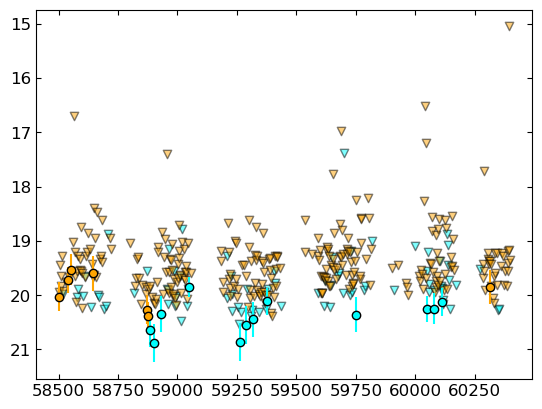

{'c': [{'mag': 19.97958361837078, 'err': 9999, 'mjd': 58520.650359},
  {'mag': 20.037237733904554, 'err': 9999, 'mjd': 58576.54079166666},
  {'mag': 19.880197503566336, 'err': 9999, 'mjd': 58580.506838500005},
  {'mag': 20.02357229107236, 'err': 9999, 'mjd': 58604.454786333336},
  {'mag': 19.65257498915995, 'err': 9999, 'mjd': 58612.37324},
  {'mag': 20.22352709377073, 'err': 9999, 'mjd': 58636.3856855},
  {'mag': 20.000757771961258, 'err': 9999, 'mjd': 58664.272567},
  {'mag': 20.037237733904554, 'err': 9999, 'mjd': 58668.34346433333},
  {'mag': 20.25457438980049, 'err': 9999, 'mjd': 58692.28002125},
  {'mag': 20.19365390302773, 'err': 9999, 'mjd': 58700.28993725},
  {'mag': 18.880241440592922, 'err': 9999, 'mjd': 58708.27979225},
  {'mag': 19.965451716620652, 'err': 9999, 'mjd': 58816.60957866666},
  {'mag': 19.54909327626439, 'err': 9999, 'mjd': 58872.604043},
  {'mag': 20.64691299187052,
   'err': 0.31110789401218103,
   'mjd': 58884.59925674999},
  {'mag': 20.885715685843792,
   '

In [7]:
%matplotlib inline
plt.figure()
get_mag_from_atlas_fp('../../data/forced_phot_data/sn20ano_atlas.txt')

Not enough epochs to estimate baseline for  ZTF_g
Not enough epochs to estimate baseline for  ZTF_g
Not enough epochs to estimate baseline for  ZTF_g
ZTF_g -1.615534490095355
ZTF_g 0.4326933422282775
Not enough epochs to estimate baseline for  ZTF_g
Not enough epochs to estimate baseline for  ZTF_g
Not enough epochs to estimate baseline for  ZTF_g
Not enough epochs to estimate baseline for  ZTF_r
Not enough epochs to estimate baseline for  ZTF_r
Not enough epochs to estimate baseline for  ZTF_r
ZTF_r -1.14475836363994
ZTF_r -2.7649175633022054
Not enough epochs to estimate baseline for  ZTF_r
Not enough epochs to estimate baseline for  ZTF_r
Not enough epochs to estimate baseline for  ZTF_r
Not enough epochs to estimate baseline for  ZTF_i
Not enough epochs to estimate baseline for  ZTF_i
Not enough epochs to estimate baseline for  ZTF_i
ZTF_i -2.37893627813627
ZTF_i 4.43207121027092
Not enough epochs to estimate baseline for  ZTF_i
Not enough epochs to estimate baseline for  ZTF_i
Not

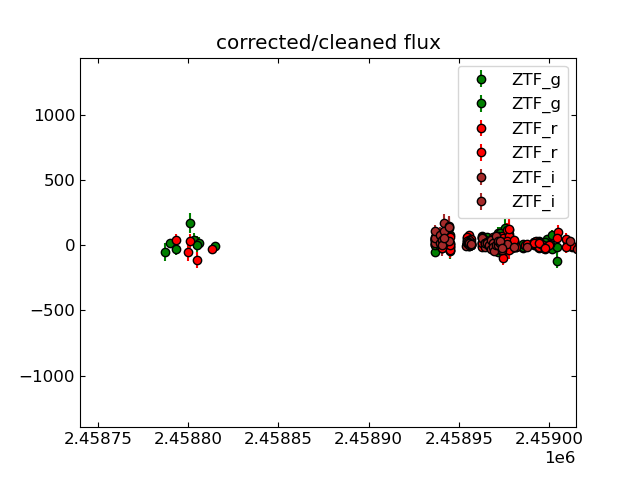

/var/folders/ql/0nrbq6jj6ks_2gbxfdznzzlc0000gp/T/ipykernel_34684/3809602937.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(['pid', 'forcediffimflux', 'forcediffimfluxunc'],


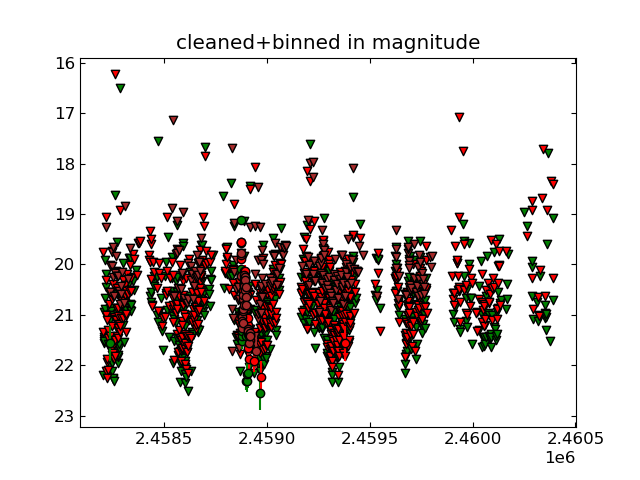

{'ZTF_g': [{'mag': 0.0, 'err': 9999, 'mjd': 58202.32800657675},
  {'mag': 0.0, 'err': 9999, 'mjd': 58203.370642350055},
  {'mag': 0.0, 'err': 9999, 'mjd': 58204.318364191335},
  {'mag': 0.0, 'err': 9999, 'mjd': 58205.343226280995},
  {'mag': 0.0, 'err': 9999, 'mjd': 58206.32547138166},
  {'mag': 0.0, 'err': 9999, 'mjd': 58207.34449587809},
  {'mag': 0.0, 'err': 9999, 'mjd': 58208.3460734915},
  {'mag': 0.0, 'err': 9999, 'mjd': 58210.318532181904},
  {'mag': 0.0, 'err': 9999, 'mjd': 58211.33349768026},
  {'mag': 0.0, 'err': 9999, 'mjd': 58214.2771342597},
  {'mag': 0.0, 'err': 9999, 'mjd': 58215.26718749991},
  {'mag': 0.0, 'err': 9999, 'mjd': 58223.318755799904},
  {'mag': 0.0, 'err': 9999, 'mjd': 58227.31560618756},
  {'mag': 0.0, 'err': 9999, 'mjd': 58229.297126725316},
  {'mag': 0.0, 'err': 9999, 'mjd': 58230.33475178899},
  {'mag': 0.0, 'err': 9999, 'mjd': 58232.1983261127},
  {'mag': 0.0, 'err': 9999, 'mjd': 58233.27172455005},
  {'mag': 0.0, 'err': 9999, 'mjd': 58234.218252300285

In [23]:
%matplotlib ipympl
ztf_df = process_ztf_fp('../../data/forced_phot_data/20ano_fp_lc.txt', 840+2.458e6 , 915+2.458e6)
get_mag_from_ztf_fp(ztf_df)

In [114]:
################################################
#    loading in cleaned and averaged data
################################################

In [94]:
sn20ano_at_cl_c = pd.read_csv('../unclean_data/2020ano/2020ano.c.1.00days.lc.txt',delim_whitespace=True)
sn20ano_at_cl_o = pd.read_csv('../unclean_data/2020ano/2020ano.o.1.00days.lc.txt',delim_whitespace=True)

In [95]:
sn20ano_at_cl_c = sn20ano_at_cl_c.dropna(axis=0, ignore_index=True, subset='MJD')
print(len(sn20ano_at_cl_c.MJD))
sn20ano_at_cl_o = sn20ano_at_cl_o.dropna(axis=0, ignore_index=True, subset='MJD')
print(len(sn20ano_at_cl_o.MJD))

133
526


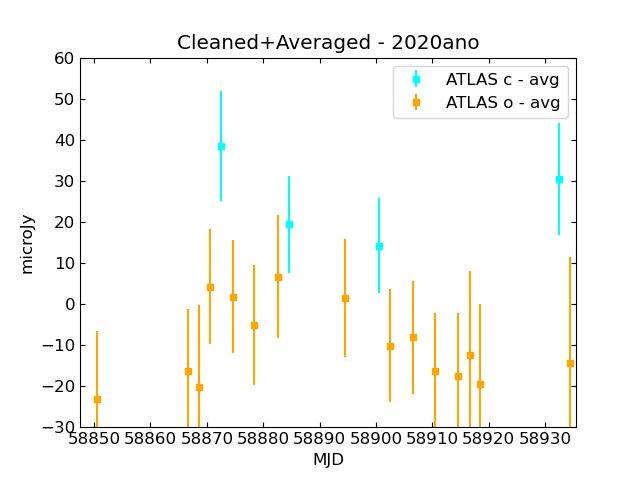

In [97]:
plt.figure()
#atlas
plt.errorbar(sn20ano_at_cl_c.MJD, sn20ano_at_cl_c.uJy, yerr=sn20ano_at_cl_c.duJy, 
             linestyle='', marker='s', color='cyan', markersize=5, label='ATLAS c - avg')
plt.errorbar(sn20ano_at_cl_o.MJD, sn20ano_at_cl_o.uJy, yerr=sn20ano_at_cl_o.duJy, 
             linestyle='', marker='s', color='orange', markersize=5, label='ATLAS o - avg')
#ZTF
# ...

#fake atlas
# plt.errorbar(jd_o_avgs-2400000.5, flux_o_avgs, flux_o_errs, linestyle='', marker='*', color='red', markersize=10)


plt.xlim(58847.5,58935.5)
# plt.ylim(19,20)
plt.ylim(-30, 60)
plt.legend()
plt.title('Cleaned+Averaged - 2020ano')
plt.xlabel('MJD')
plt.ylabel('microJy')
plt.show()

In [63]:
# ztf
print('pre-cut length:', len(sn20ano_ztf['forcediffimflux']))
bad_cuts = (sn20ano_ztf['infobitssci']>33554432) | (sn20ano_ztf['scisigpix'] > 25) | (sn20ano_ztf['sciinpseeing']>4)
# good_cuts = ~bad_cuts
sn20ano_ztf_good = sn20ano_ztf[~bad_cuts]
print('post-cut length:', len(sn20ano_ztf_good['forcediffimflux']))
print('removed:', len(sn20ano_ztf['forcediffimflux'])-len(sn20ano_ztf_good['forcediffimflux']))

pre-cut length: 3919
post-cut length: 3682
removed: 237


Text(0, 0.5, 'mag')

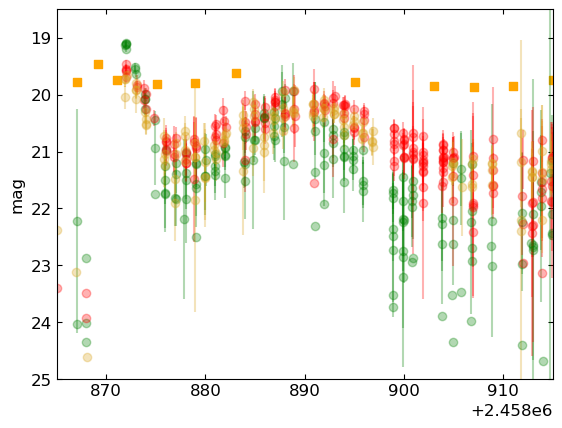

In [74]:
# plot mags
plt.figure()
err_g = shape_err(sn20ano_ztf_good, filter='ZTF_g')
err_r = shape_err(sn20ano_ztf_good, filter='ZTF_r')
err_i = shape_err(sn20ano_ztf_good, filter='ZTF_i')

plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_g']['jd'], sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_g']['mag'], err_g,
                color='green', alpha=0.3, label='ZTF_g', linestyle='', marker='o')
plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_r']['jd'], sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_r']['mag'], err_r,
            color='red', alpha=0.3, label='ZTF_r', linestyle='', marker='o')
plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_i']['jd'], sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_i']['mag'], err_i,
            color='goldenrod', alpha=0.3, label='ZTF_i', linestyle='', marker='o')

plt.scatter(sn20ano_at_cl_o.MJD+2400000.5, sn20ano_at_cl_o.m, marker='s', color='orange')


plt.xlim(865+2.458e6, 915+2.458e6)
plt.ylim(25,18.5)
plt.ylabel('mag')

#plot flux
# %matplotlib qt
# plt.figure()
# plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_g']['jd'],
#              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_g']['forcediffimflux'],
#              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_g']['forcediffimfluxunc'],
#                 color='green', alpha=0.3, label='ZTF_g', linestyle='', marker='o')
# plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_r']['jd'],
#              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_r']['forcediffimflux'],
#              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_r']['forcediffimfluxunc'],
#              color='red', alpha=0.3, label='ZTF_r', linestyle='', marker='o')
# plt.errorbar(sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_i']['jd'],
#              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_i']['forcediffimflux'],
#              sn20ano_ztf_good[sn20ano_ztf_good['filter']=='ZTF_i']['forcediffimfluxunc'],
#              color='goldenrod', alpha=0.3, label='ZTF_i', linestyle='', marker='o')
# # plt.axhline(y=0, zorder=0, color='k')
# # plt.axhline(y=75, zorder=0, color='k')
# plt.xlim(855+2.458e6, 920+2.458e6)
# plt.ylabel('flux')